<a href="https://colab.research.google.com/github/anjalii-s/Thesis-2026-/blob/main/German_Myerson_Cosine_Kuncheva_initial_test_with_only_smote_and_none.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using smote and none only

Loading dataset...

EXTENDED CREDIT RISK ANALYSIS WITH MYERSON VALUE

--- Processing RF + None ---
  Fold 1: AUC = 0.7732
  Fold 2: AUC = 0.7721
  Fold 3: AUC = 0.8286
  Fold 4: AUC = 0.7650

--- Processing RF + SMOTE ---
  Fold 1: AUC = 0.7955
  Fold 2: AUC = 0.7524
  Fold 3: AUC = 0.8218
  Fold 4: AUC = 0.7703

--- Processing XGB + None ---
  Fold 1: AUC = 0.7314
  Fold 2: AUC = 0.7728
  Fold 3: AUC = 0.7928
  Fold 4: AUC = 0.7725

--- Processing XGB + SMOTE ---
  Fold 1: AUC = 0.7375
  Fold 2: AUC = 0.7563
  Fold 3: AUC = 0.7827
  Fold 4: AUC = 0.7813

--- Processing LGB + None ---
  Fold 1: AUC = 0.7360
  Fold 2: AUC = 0.7670
  Fold 3: AUC = 0.7891
  Fold 4: AUC = 0.7906

--- Processing LGB + SMOTE ---
  Fold 1: AUC = 0.7517
  Fold 2: AUC = 0.7710
  Fold 3: AUC = 0.8120
  Fold 4: AUC = 0.7826

EXTENDED RESULTS WITH ALL EXPLANATION METHODS
Model Sampler        Method    AUC     CV  Stability  Cosine  Kuncheva  I_Extended      Group_Q  T(α=0.5)
   RF    None          SHAP 0.7847 0.66

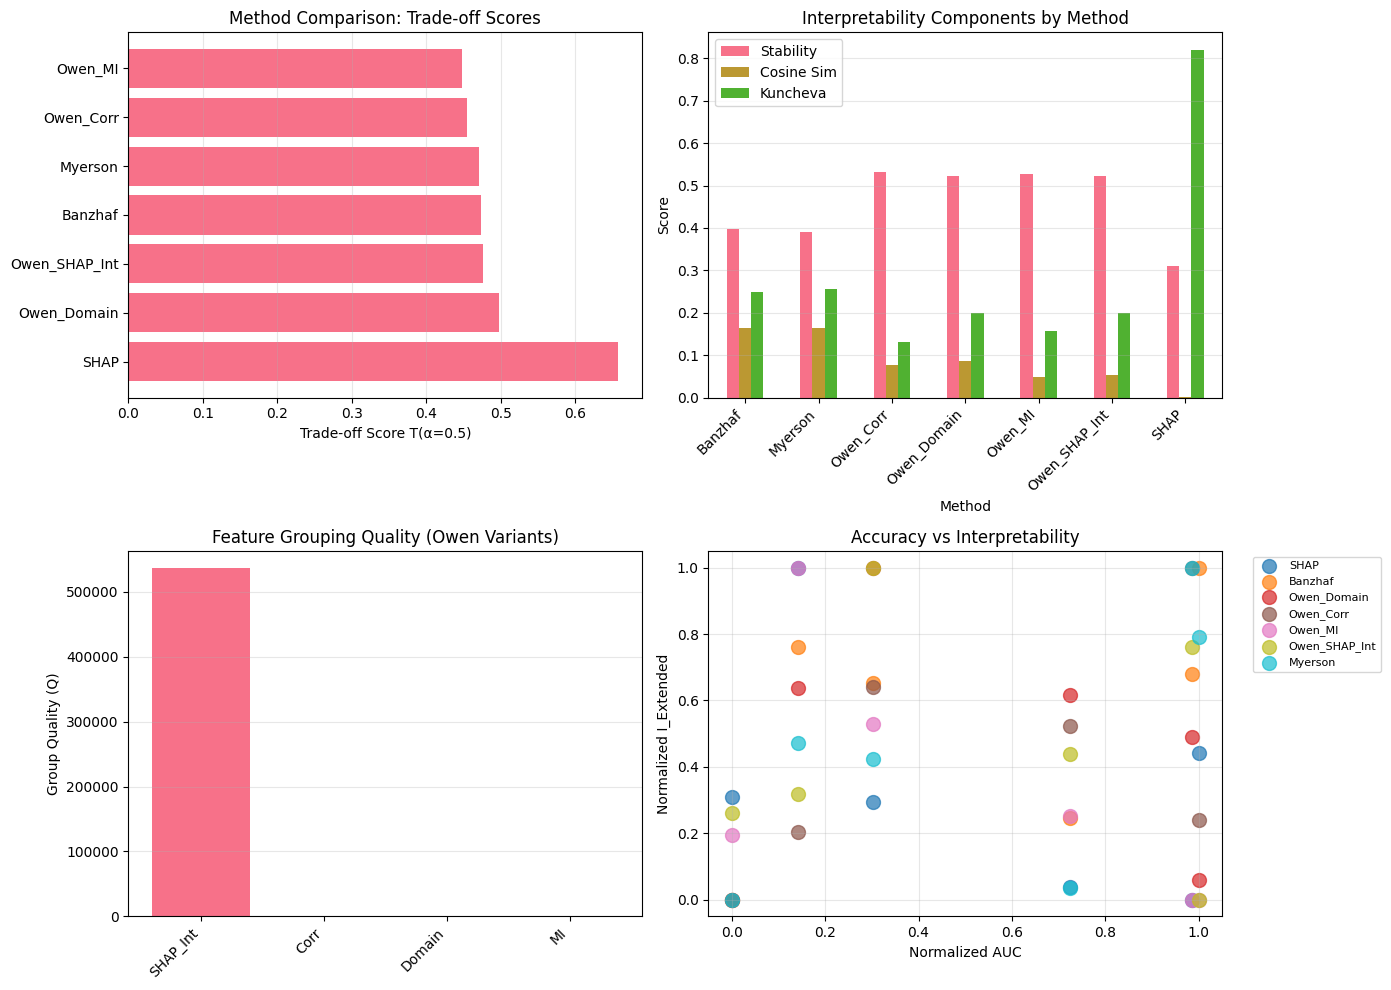


KEY FINDINGS

1. Best Overall Method: SHAP
   Trade-off Score: 0.6570

3. Group Quality Rankings:
   Owen_SHAP_Int: Q = 536159.9217
   Owen_Corr: Q = 2.1798
   Owen_Domain: Q = 1.5788
   Owen_MI: Q = 1.1184

4. Interpretability Components (Overall Averages):
   Stability: 0.4574
   Cosine: 0.0849
   Kuncheva: 0.2877

ANALYSIS COMPLETE

STATISTICAL VALIDATION SUITE — EXTENDED ANALYSIS

1. FRIEDMAN TEST — Model Comparisons

--- AUC ---
  Statistic: 28.0000
  p-value: 0.000001 (SIGNIFICANT)
  Kendall's W: 1.0000 (large)

--- I_Extended ---
  Statistic: 1.2857
  p-value: 0.525788 (not significant)
  Kendall's W: 0.0459 (negligible)

--- T(α=0.5) ---
  Statistic: 20.5714
  p-value: 0.000034 (SIGNIFICANT)
  Kendall's W: 0.7347 (large)

2. NEMENYI POST-HOC TEST — Pairwise Model Comparisons

--- AUC ---
  Mean Ranks: {'RF': np.float64(3.0), 'XGB': np.float64(1.0), 'LGB': np.float64(2.0)}
  Critical Difference (CD): 0.8856
  Pairwise Comparisons:
    RF vs XGB: |rank diff| = 2.0000 → SIGNIFICA

In [5]:
# ===============================
# Extended German Credit Experiment
# With Myerson Value & Advanced Feature Grouping
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
import xgboost as xgb
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from itertools import combinations

plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

# ===============================
# Load & Preprocess Dataset
# ===============================
print("Loading dataset...")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
cols = ['checking_status','duration','credit_history','purpose','credit_amount',
        'savings_status','employment','installment_commitment','personal_status',
        'other_parties','residence_since','property_magnitude','age',
        'other_payment_plans','housing','existing_credits','job',
        'num_dependents','own_telephone','foreign_worker','target']

df = pd.read_csv(url, sep=' ', header=None, names=cols)
df['target'] = df['target'].map({1:0, 2:1})

X, y = df.drop('target', axis=1), df['target']
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include='number').columns

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# ===============================
# Domain-Driven Feature Groups
# ===============================
domain_groups = {
    'Demographics': ['age', 'personal_status', 'foreign_worker', 'own_telephone'],
    'Financial': ['checking_status', 'savings_status', 'credit_amount', 'property_magnitude'],
    'Credit_History': ['credit_history', 'duration', 'purpose', 'existing_credits',
                       'installment_commitment', 'other_payment_plans'],
    'Other': ['other_parties', 'residence_since', 'num_dependents', 'job', 'employment', 'housing']
}

# ===============================
# Feature Grouping Functions
# ===============================

def create_correlation_groups(X_transformed, feature_names, n_groups=4, threshold=0.7):
    """Data-driven grouping based on correlation clustering"""
    # Compute correlation matrix
    corr_matrix = np.corrcoef(X_transformed.T)

    # Convert to distance matrix
    dist_matrix = 1 - np.abs(corr_matrix)
    dist_matrix = (dist_matrix + dist_matrix.T) / 2  # Ensure symmetry
    np.fill_diagonal(dist_matrix, 0)

    # Hierarchical clustering
    condensed_dist = squareform(dist_matrix, checks=False)
    linkage_matrix = linkage(condensed_dist, method='average')

    # Cut tree to get clusters
    labels = fcluster(linkage_matrix, n_groups, criterion='maxclust')

    # Create groups dictionary
    groups = {}
    for i in range(1, n_groups + 1):
        group_features = [feature_names[j] for j in range(len(feature_names)) if labels[j] == i]
        if group_features:  # Only add non-empty groups
            groups[f'Group_{i}'] = group_features

    return groups

def create_mi_groups(X_transformed, y_train, feature_names, n_groups=4):
    """Data-driven grouping based on mutual information similarity"""
    # Compute mutual information with target
    mi_scores = mutual_info_classif(X_transformed, y_train, random_state=42)

    # Sort features by MI and divide into groups
    sorted_indices = np.argsort(mi_scores)[::-1]
    group_size = len(sorted_indices) // n_groups

    groups = {}
    for i in range(n_groups):
        start_idx = i * group_size
        end_idx = start_idx + group_size if i < n_groups - 1 else len(sorted_indices)
        group_features = [feature_names[j] for j in sorted_indices[start_idx:end_idx]]
        if group_features:  # Only add non-empty groups
            groups[f'MI_Group_{i+1}'] = group_features

    return groups

def create_shap_interaction_groups_simple(pipe, X_sample, feature_names, n_groups=4):
    """Simplified SHAP-based grouping using absolute SHAP values"""
    clf = pipe.named_steps['clf']
    prep = pipe.named_steps['prep']
    X_proc = prep.transform(X_sample)

    try:
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_proc)

        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Use positive class

        # Use absolute SHAP values for similarity
        shap_abs = np.abs(shap_values)

        # Compute similarity based on SHAP value correlations
        n_features = shap_abs.shape[1]
        similarity_matrix = np.zeros((n_features, n_features))

        for i in range(n_features):
            for j in range(i+1, n_features):
                # Pearson correlation of absolute SHAP values
                with np.errstate(invalid='ignore'):
                    corr_matrix = np.corrcoef(shap_abs[:, i], shap_abs[:, j])
                    corr = corr_matrix[0, 1] if not np.isnan(corr_matrix[0, 1]) else 0
                    similarity = abs(corr)
                    similarity_matrix[i, j] = similarity
                    similarity_matrix[j, i] = similarity

        np.fill_diagonal(similarity_matrix, 1.0)

        # Convert to distance matrix
        dist_matrix = 1 - similarity_matrix

        # Ensure perfect symmetry
        dist_matrix = (dist_matrix + dist_matrix.T) / 2
        np.fill_diagonal(dist_matrix, 0)

        # Cluster
        condensed_dist = squareform(dist_matrix, checks=False)
        linkage_matrix = linkage(condensed_dist, method='average')
        labels = fcluster(linkage_matrix, n_groups, criterion='maxclust')

        # Create groups
        groups = {}
        for i in range(1, n_groups + 1):
            group_features = [feature_names[j] for j in range(len(feature_names)) if labels[j] == i]
            if group_features:
                groups[f'SHAP_Group_{i}'] = group_features

        return groups

    except Exception as e:
        print(f"SHAP failed: {str(e)}. Using correlation fallback.")
        return create_correlation_groups(X_proc, feature_names, n_groups)

def compute_group_quality(X_transformed, groups, feature_names):
    """Compute Q = within-group dependence / across-group dependence"""
    corr_matrix = np.abs(np.corrcoef(X_transformed.T))

    # Map feature names to indices
    feature_to_idx = {name: i for i, name in enumerate(feature_names)}

    within_group_deps = []
    across_group_deps = []

    # Within-group dependencies
    for group_name, group_features in groups.items():
        indices = [feature_to_idx.get(f) for f in group_features if f in feature_to_idx]
        indices = [i for i in indices if i is not None]

        if len(indices) > 1:
            for i, j in combinations(indices, 2):
                within_group_deps.append(corr_matrix[i, j])

    # Across-group dependencies
    group_list = list(groups.keys())
    for g1, g2 in combinations(group_list, 2):
        indices1 = [feature_to_idx.get(f) for f in groups[g1] if f in feature_to_idx]
        indices2 = [feature_to_idx.get(f) for f in groups[g2] if f in feature_to_idx]
        indices1 = [i for i in indices1 if i is not None]
        indices2 = [i for i in indices2 if i is not None]

        for i in indices1:
            for j in indices2:
                across_group_deps.append(corr_matrix[i, j])

    within_mean = np.mean(within_group_deps) if within_group_deps else 0
    across_mean = np.mean(across_group_deps) if across_group_deps else 1e-8

    Q = within_mean / (across_mean + 1e-8)
    return Q, within_mean, across_mean

def map_original_to_transformed_groups(original_groups, feature_names):
    """Map original feature groups to one-hot encoded feature names"""
    transformed_groups = {}

    for group_name, original_features in original_groups.items():
        matched_features = []
        for orig_feat in original_features:
            # Find all transformed features that contain this original feature name
            matched = [f for f in feature_names if orig_feat in f]
            matched_features.extend(matched)

        if matched_features:
            transformed_groups[group_name] = matched_features

    return transformed_groups

# ===============================
# Myerson Value Implementation
# ===============================

def build_feature_graph(X_transformed, feature_names, threshold=0.3):
    """Build feature dependency graph based on correlation"""
    corr_matrix = np.abs(np.corrcoef(X_transformed.T))

    # Create adjacency matrix
    adjacency = (corr_matrix > threshold).astype(int)
    np.fill_diagonal(adjacency, 0)

    return adjacency

def get_connected_components(adjacency, coalition):
    """Find connected components in a coalition"""
    n = len(coalition)
    visited = [False] * n
    components = []

    def dfs(node, component):
        visited[node] = True
        component.append(coalition[node])
        for neighbor in range(n):
            if not visited[neighbor] and adjacency[coalition[node], coalition[neighbor]] == 1:
                dfs(neighbor, component)

    for i in range(n):
        if not visited[i]:
            component = []
            dfs(i, component)
            components.append(component)

    return components

def compute_myerson(pipe, X_test, adjacency, n_samples=5, max_instances=5):
    """Compute Myerson value with graph-restricted coalitions"""
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)

    n_features = X_proc.shape[1]
    n_instances = min(max_instances, X_proc.shape[0])
    myerson_matrix = np.zeros((n_instances, n_features))

    for i in range(n_instances):
        x_instance = X_proc[i:i+1]

        for f in range(n_features):
            contributions = []

            for _ in range(n_samples):
                # Sample coalition
                coalition_mask = np.random.binomial(1, 0.5, n_features)
                coalition = [j for j in range(n_features) if coalition_mask[j] == 1]

                # Get connected components
                if len(coalition) > 0:
                    components_without = get_connected_components(adjacency, [c for c in coalition if c != f])

                    # Compute value for connected components without f
                    mask_without = np.zeros(n_features)
                    for comp in components_without:
                        mask_without[comp] = 1
                    pred_without = clf.predict_proba(x_instance * mask_without.reshape(1, -1))[0, 1]

                    # Add f and recompute
                    coalition_with = coalition if f in coalition else coalition + [f]
                    components_with = get_connected_components(adjacency, coalition_with)
                    mask_with = np.zeros(n_features)
                    for comp in components_with:
                        mask_with[comp] = 1
                    pred_with = clf.predict_proba(x_instance * mask_with.reshape(1, -1))[0, 1]

                    contributions.append(pred_with - pred_without)
                else:
                    contributions.append(0)

            myerson_matrix[i, f] = np.mean(contributions)

    return myerson_matrix

# ===============================
# Enhanced Interpretability Metrics
# ===============================

def cosine_similarity_cv(expl_list):
    """Directional stability via cosine similarity"""
    if len(expl_list) < 2:
        return 1.0

    similarities = []
    for i in range(len(expl_list)):
        for j in range(i+1, len(expl_list)):
            exp1 = np.array(expl_list[i]).flatten()
            exp2 = np.array(expl_list[j]).flatten()

            norm1 = np.linalg.norm(exp1)
            norm2 = np.linalg.norm(exp2)

            if norm1 > 1e-8 and norm2 > 1e-8:
                sim = np.dot(exp1, exp2) / (norm1 * norm2)
                similarities.append(sim)

    return float(np.mean(similarities)) if similarities else 0.0

def kuncheva_index(expl_list, k=5):
    """Kuncheva index for top-K feature consistency"""
    if len(expl_list) < 2:
        return 0.0

    sets = []
    d = np.array(expl_list[0]).shape[1] if len(np.array(expl_list[0]).shape) > 1 else len(np.array(expl_list[0]))

    for exp in expl_list:
        imp = np.abs(np.array(exp)).mean(axis=0).ravel()
        topk = set(int(i) for i in np.argsort(imp)[-k:])
        sets.append(topk)

    kuncheva_scores = []
    for i in range(len(sets)):
        for j in range(i+1, len(sets)):
            intersection = len(sets[i] & sets[j])
            numerator = intersection - (k * k) / d
            denominator = k - (k * k) / d
            if denominator > 1e-8:
                kuncheva_scores.append(numerator / denominator)

    return float(np.mean(kuncheva_scores)) if kuncheva_scores else 0.0

def extended_interpretability_score(expl_list, beta1=0.4, beta2=0.3, beta3=0.3, k=5):
    """Extended interpretability: I = β1(1-CV) + β2·C + β3·Kc"""
    cv_val = stability_cv(expl_list)
    cosine_val = cosine_similarity_cv(expl_list)
    kuncheva_val = kuncheva_index(expl_list, k=k)

    I_extended = beta1 * (1 - cv_val) + beta2 * cosine_val + beta3 * kuncheva_val

    return I_extended, cv_val, cosine_val, kuncheva_val

def stability_cv(expl_list):
    """Original CV-based stability"""
    if len(expl_list) < 2:
        return 1.0
    arr = np.stack([np.abs(np.array(exp)) for exp in expl_list])
    mean = arr.mean(axis=0) + 1e-8
    std = arr.std(axis=0)
    return float(np.nanmean((std / mean).mean(axis=0)))

# ===============================
# SHAP & Banzhaf (from original)
# ===============================

def get_shap_reliable(pipe, X_test):
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        return sv[1] if isinstance(sv, list) else sv
    except:
        from sklearn.inspection import permutation_importance
        result = permutation_importance(clf, X_proc, pipe.predict(X_proc), n_repeats=3, random_state=42)
        return np.tile(result.importances_mean, (X_proc.shape[0], 1))

def compute_banzhaf(pipe, X_test, n_samples=5, max_instances=5):
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_features = X_proc.shape[1]
    n_instances = min(max_instances, X_proc.shape[0])
    banzhaf_matrix = np.zeros((n_instances, n_features))

    for i in range(n_instances):
        x_instance = X_proc[i:i+1]
        for f in range(n_features):
            contributions = []
            for _ in range(n_samples):
                coalition = np.random.binomial(1, 0.5, n_features)
                coalition[f] = 0
                pred_without = clf.predict_proba(x_instance * coalition.reshape(1, -1))[0, 1]
                coalition[f] = 1
                pred_with = clf.predict_proba(x_instance * coalition.reshape(1, -1))[0, 1]
                contributions.append(pred_with - pred_without)
            banzhaf_matrix[i, f] = np.mean(contributions)

    return banzhaf_matrix

def compute_owen(pipe, X_test, feature_groups, n_samples=3, max_instances=5):
    clf = pipe.named_steps['clf']
    prep = pipe.named_steps['prep']
    X_proc = prep.transform(X_test)
    feature_names = prep.get_feature_names_out()

    group_indices = {g: [i for i, name in enumerate(feature_names) if any(f in name for f in feats)]
                     for g, feats in feature_groups.items()}

    n_features = X_proc.shape[1]
    n_instances = min(max_instances, X_proc.shape[0])
    owen_matrix = np.zeros((n_instances, n_features))

    for i in range(n_instances):
        x_instance = X_proc[i:i+1]
        for f in range(n_features):
            contributions = []
            for _ in range(n_samples):
                group_mask = {g: np.random.choice([0, 1]) for g in group_indices}
                mask = np.zeros(n_features)
                for g, idxs in group_indices.items():
                    if group_mask[g] == 1:
                        if f in idxs:
                            for idx in idxs:
                                mask[idx] = np.random.choice([0, 1])
                        else:
                            mask[idxs] = 1
                mask_without = mask.copy()
                mask_without[f] = 0
                pred_without = clf.predict_proba(x_instance * mask_without)[0, 1]
                pred_with = clf.predict_proba(x_instance * mask)[0, 1]
                contributions.append(pred_with - pred_without)
            owen_matrix[i, f] = np.mean(contributions)

    return owen_matrix

# ===============================
# Cross-Validation with All Methods
# ===============================

def normalize(series):
    return (series - series.min()) / (series.max() - series.min() + 1e-8)

def tradeoff_metric(auc_series, I_series, alpha=0.5):
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

# Models
models = {
    'RF': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'XGB': xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42, eval_metric='logloss', base_score=0.5),
    'LGB': lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42, verbose=-1)
}

# Simplified samplers for demonstration
resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
records = []

print("\n" + "="*80)
print("EXTENDED CREDIT RISK ANALYSIS WITH MYERSON VALUE")
print("="*80)

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        print(f"\n--- Processing {mname} + {sname} ---")

        aucs = []
        shap_runs, banzhaf_runs = [], []
        owen_domain_runs, owen_corr_runs, owen_mi_runs, owen_shap_runs = [], [], [], []
        myerson_runs = []

        group_qualities = {'Domain': [], 'Correlation': [], 'MI': [], 'SHAP_Interact': []}

        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            # Build pipeline
            steps = [('prep', preprocessor)]
            if sampler:
                steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)

            # Fit
            pipe.fit(X_tr, y_tr)
            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
            aucs.append(auc)
            print(f"  Fold {fold}: AUC = {auc:.4f}")

            # Get transformed feature names
            feature_names = pipe.named_steps['prep'].get_feature_names_out()
            X_tr_proc = pipe.named_steps['prep'].transform(X_tr)
            X_te_sample = X_te.sample(n=min(30, len(X_te)), random_state=42)

            # Create different feature groups (on training data only)
            groups_domain = map_original_to_transformed_groups(domain_groups, feature_names)
            groups_corr = create_correlation_groups(X_tr_proc, feature_names, n_groups=4)
            groups_mi = create_mi_groups(X_tr_proc, y_tr, feature_names, n_groups=4)
            groups_shap_int = create_shap_interaction_groups_simple(pipe, X_tr.sample(n=min(50, len(X_tr)), random_state=42),
                                                                    feature_names, n_groups=4)

            # Compute group quality
            Q_domain, _, _ = compute_group_quality(X_tr_proc, groups_domain, feature_names)
            Q_corr, _, _ = compute_group_quality(X_tr_proc, groups_corr, feature_names)
            Q_mi, _, _ = compute_group_quality(X_tr_proc, groups_mi, feature_names)
            Q_shap, _, _ = compute_group_quality(X_tr_proc, groups_shap_int, feature_names)

            group_qualities['Domain'].append(Q_domain)
            group_qualities['Correlation'].append(Q_corr)
            group_qualities['MI'].append(Q_mi)
            group_qualities['SHAP_Interact'].append(Q_shap)

            # Build graph for Myerson
            X_te_proc = pipe.named_steps['prep'].transform(X_te_sample)
            adjacency = build_feature_graph(X_te_proc, feature_names, threshold=0.3)

            # Compute explanations (with safety checks)
            try:
                shap_runs.append(get_shap_reliable(pipe, X_te_sample))
                banzhaf_runs.append(compute_banzhaf(pipe, X_te_sample, n_samples=3, max_instances=3))
                owen_domain_runs.append(compute_owen(pipe, X_te_sample, groups_domain, n_samples=2, max_instances=3))
                owen_corr_runs.append(compute_owen(pipe, X_te_sample, groups_corr, n_samples=2, max_instances=3))
                owen_mi_runs.append(compute_owen(pipe, X_te_sample, groups_mi, n_samples=2, max_instances=3))
                owen_shap_runs.append(compute_owen(pipe, X_te_sample, groups_shap_int, n_samples=2, max_instances=3))
                myerson_runs.append(compute_myerson(pipe, X_te_sample, adjacency, n_samples=3, max_instances=3))
            except Exception as e:
                print(f"    Warning: Explanation computation failed for fold {fold}: {str(e)}")
                # Add zeros as fallback
                n_features = len(feature_names)
                n_instances = min(3, len(X_te_sample))
                zero_expl = np.zeros((n_instances, n_features))
                shap_runs.append(zero_expl)
                banzhaf_runs.append(zero_expl)
                owen_domain_runs.append(zero_expl)
                owen_corr_runs.append(zero_expl)
                owen_mi_runs.append(zero_expl)
                owen_shap_runs.append(zero_expl)
                myerson_runs.append(zero_expl)

        auc_mean = np.mean(aucs)

        # Evaluate all methods
        methods_data = [
            ('SHAP', shap_runs),
            ('Banzhaf', banzhaf_runs),
            ('Owen_Domain', owen_domain_runs),
            ('Owen_Corr', owen_corr_runs),
            ('Owen_MI', owen_mi_runs),
            ('Owen_SHAP_Int', owen_shap_runs),
            ('Myerson', myerson_runs)
        ]

        for method_name, expl_runs in methods_data:
            try:
                I_ext, cv_val, cosine_val, kuncheva_val = extended_interpretability_score(expl_runs, k=5)
            except Exception as e:
                print(f"    Warning: Interpretability score failed for {method_name}: {str(e)}")
                I_ext, cv_val, cosine_val, kuncheva_val = 0.5, 0.5, 0.5, 0.5

            # Get group quality if Owen variant
            Q_val = None
            if 'Owen' in method_name:
                if 'Domain' in method_name:
                    Q_val = np.mean(group_qualities['Domain'])
                elif 'Corr' in method_name:
                    Q_val = np.mean(group_qualities['Correlation'])
                elif 'MI' in method_name:
                    Q_val = np.mean(group_qualities['MI'])
                elif 'SHAP_Int' in method_name:
                    Q_val = np.mean(group_qualities['SHAP_Interact'])

            records.append({
                'Model': mname,
                'Sampler': sname,
                'Method': method_name,
                'AUC': auc_mean,
                'CV': cv_val,
                'Stability': 1 - cv_val,
                'Cosine': cosine_val,
                'Kuncheva': kuncheva_val,
                'I_Extended': I_ext,
                'Group_Q': Q_val if Q_val is not None else np.nan
            })

# ===============================
# Results Analysis
# ===============================

results_df = pd.DataFrame(records)
results_df['T(α=0.5)'] = tradeoff_metric(results_df['AUC'], results_df['I_Extended'])

print("\n" + "="*80)
print("EXTENDED RESULTS WITH ALL EXPLANATION METHODS")
print("="*80)
print(results_df.round(4).to_string(index=False))

# ===============================
# Comparative Analysis
# ===============================

print("\n" + "="*80)
print("AVERAGE PERFORMANCE BY METHOD")
print("="*80)
method_summary = results_df.groupby('Method').agg({
    'AUC': 'mean',
    'Stability': 'mean',
    'Cosine': 'mean',
    'Kuncheva': 'mean',
    'I_Extended': 'mean',
    'Group_Q': 'mean',
    'T(α=0.5)': 'mean'
}).round(4)
print(method_summary)

# ===============================
# Visualization
# ===============================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Trade-off comparison
ax = axes[0, 0]
method_avg = results_df.groupby('Method')['T(α=0.5)'].mean().sort_values(ascending=False)
ax.barh(range(len(method_avg)), method_avg.values)
ax.set_yticks(range(len(method_avg)))
ax.set_yticklabels(method_avg.index)
ax.set_xlabel('Trade-off Score T(α=0.5)')
ax.set_title('Method Comparison: Trade-off Scores')
ax.grid(axis='x', alpha=0.3)

# 2. Extended interpretability components
ax = axes[0, 1]
components = results_df.groupby('Method')[['Stability', 'Cosine', 'Kuncheva']].mean()
components.plot(kind='bar', ax=ax)
ax.set_ylabel('Score')
ax.set_title('Interpretability Components by Method')
ax.legend(['Stability', 'Cosine Sim', 'Kuncheva'])
ax.grid(axis='y', alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Group quality comparison (Owen variants only)
ax = axes[1, 0]
owen_results = results_df[results_df['Method'].str.contains('Owen')]
if not owen_results.empty:
    quality_data = owen_results.groupby('Method')['Group_Q'].mean().sort_values(ascending=False)
    ax.bar(range(len(quality_data)), quality_data.values)
    ax.set_xticks(range(len(quality_data)))
    ax.set_xticklabels([m.replace('Owen_', '') for m in quality_data.index], rotation=45, ha='right')
    ax.set_ylabel('Group Quality (Q)')
    ax.set_title('Feature Grouping Quality (Owen Variants)')
    ax.grid(axis='y', alpha=0.3)

# 4. Accuracy vs Interpretability scatter
ax = axes[1, 1]
methods = results_df['Method'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
for method, color in zip(methods, colors):
    subset = results_df[results_df['Method'] == method]
    ax.scatter(normalize(subset['AUC']), normalize(subset['I_Extended']),
              s=100, alpha=0.7, label=method, c=[color])
ax.set_xlabel('Normalized AUC')
ax.set_ylabel('Normalized I_Extended')
ax.set_title('Accuracy vs Interpretability')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ===============================
# Key Findings
# ===============================

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

best_method = method_summary['T(α=0.5)'].idxmax()
print(f"\n1. Best Overall Method: {best_method}")
print(f"   Trade-off Score: {method_summary.loc[best_method, 'T(α=0.5)']:.4f}")

if 'Owen' in results_df['Method'].values:
    owen_df = results_df[results_df['Method'].str.contains('Owen')]
    best_owen = owen_df.loc[owen_df['T(α=0.5)'].idxmax()]
    print(f"\n2. Best Owen Variant: {best_owen['Method']}")
    print(f"   Group Quality Q: {best_owen['Group_Q']:.4f}")
    print(f"   Trade-off Score: {best_owen['T(α=0.5)']:.4f}")

print("\n3. Group Quality Rankings:")
owen_q = results_df[results_df['Method'].str.contains('Owen')].groupby('Method')['Group_Q'].mean().sort_values(ascending=False)
for method, q_val in owen_q.items():
    print(f"   {method}: Q = {q_val:.4f}")

print("\n4. Interpretability Components (Overall Averages):")
for component in ['Stability', 'Cosine', 'Kuncheva']:
    avg_val = results_df[component].mean()
    print(f"   {component}: {avg_val:.4f}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# ============================================================
# Statistical Validation Suite — Extended German Credit Analysis
# ============================================================

from scipy import stats
from statsmodels.stats.power import TTestIndPower
import itertools

print("\n" + "="*100)
print("STATISTICAL VALIDATION SUITE — EXTENDED ANALYSIS")
print("="*100)

# ============================================================
# 1. FRIEDMAN TEST (Overall Differences Between Models)
# ============================================================

print("\n" + "="*100)
print("1. FRIEDMAN TEST — Model Comparisons")
print("="*100)

for metric in ['AUC', 'I_Extended', 'T(α=0.5)']:
    print(f"\n--- {metric} ---")

    # Pivot table: rows = (Sampler, Method), columns = Model
    pivoted = results_df.pivot_table(values=metric, index=['Sampler', 'Method'], columns='Model')

    # Check if we have all three models
    if 'RF' not in pivoted.columns or 'XGB' not in pivoted.columns or 'LGB' not in pivoted.columns:
        print(f"  Skipping {metric}: not all models present")
        continue

    if pivoted.isnull().any().any():
        print(f"  Skipping {metric}: contains missing values")
        continue

    rf = pivoted['RF'].values
    xgb = pivoted['XGB'].values
    lgb = pivoted['LGB'].values

    # Friedman test
    stat, p = stats.friedmanchisquare(rf, xgb, lgb)

    # Kendall's W (effect size)
    k = 3  # number of models
    n = len(rf)  # number of observations
    kendall_w = stat / (n * (k - 1))

    print(f"  Statistic: {stat:.4f}")
    print(f"  p-value: {p:.6f} ({'SIGNIFICANT' if p < 0.05 else 'not significant'})")
    print(f"  Kendall's W: {kendall_w:.4f}", end="")

    # Interpret effect size
    if kendall_w < 0.1:
        print(" (negligible)")
    elif kendall_w < 0.3:
        print(" (small)")
    elif kendall_w < 0.5:
        print(" (medium)")
    else:
        print(" (large)")

# ============================================================
# 2. NEMENYI POST-HOC TEST
# ============================================================

def nemenyi_posthoc(data, model_names, alpha=0.05):
    """Nemenyi post-hoc test for pairwise model comparisons"""
    # Rank each row (configuration)
    ranks = stats.rankdata(data, axis=1)
    mean_ranks = np.mean(ranks, axis=0)

    n, k = data.shape
    q_alpha = 2.343  # Critical value for k=3 at alpha=0.05
    cd = q_alpha * np.sqrt(k * (k + 1) / (6 * n))

    print(f"  Mean Ranks: {dict(zip(model_names, mean_ranks.round(4)))}")
    print(f"  Critical Difference (CD): {cd:.4f}")
    print(f"  Pairwise Comparisons:")

    for i in range(k):
        for j in range(i + 1, k):
            diff = abs(mean_ranks[i] - mean_ranks[j])
            sig = "SIGNIFICANT" if diff > cd else "not significant"
            print(f"    {model_names[i]} vs {model_names[j]}: |rank diff| = {diff:.4f} → {sig}")

print("\n" + "="*100)
print("2. NEMENYI POST-HOC TEST — Pairwise Model Comparisons")
print("="*100)

for metric in ['AUC', 'I_Extended', 'T(α=0.5)']:
    print(f"\n--- {metric} ---")
    pivoted = results_df.pivot_table(values=metric, index=['Sampler', 'Method'], columns='Model')

    if 'RF' not in pivoted.columns or 'XGB' not in pivoted.columns or 'LGB' not in pivoted.columns:
        print(f"  Skipping {metric}: not all models present")
        continue

    if pivoted.isnull().any().any():
        print(f"  Skipping {metric}: contains missing values")
        continue

    nemenyi_posthoc(pivoted[['RF', 'XGB', 'LGB']].values, ['RF', 'XGB', 'LGB'])

# ============================================================
# 3. WILCOXON SIGNED-RANK TEST
# ============================================================

print("\n" + "="*100)
print("3. WILCOXON SIGNED-RANK TEST — Pairwise Model Comparisons")
print("="*100)

pairs = [('RF', 'XGB'), ('RF', 'LGB'), ('XGB', 'LGB')]

for metric in ['AUC', 'I_Extended', 'T(α=0.5)']:
    print(f"\n--- {metric} ---")

    for m1, m2 in pairs:
        df1 = results_df[results_df['Model'] == m1][metric].values
        df2 = results_df[results_df['Model'] == m2][metric].values

        if len(df1) != len(df2):
            print(f"  {m1} vs {m2}: sample sizes differ, skipping")
            continue

        stat, p = stats.wilcoxon(df1, df2, zero_method='zsplit')
        print(f"  {m1} vs {m2}: statistic = {stat:.3f}, p = {p:.6f} ({'SIGNIFICANT' if p < 0.05 else 'not significant'})")

# ============================================================
# 4. CLIFF'S DELTA (Effect Size)
# ============================================================

def cliffs_delta(x, y):
    """Compute Cliff's delta effect size"""
    n1, n2 = len(x), len(y)
    greater = sum(xi > yj for xi in x for yj in y)
    lesser = sum(xi < yj for xi in x for yj in y)
    return (greater - lesser) / (n1 * n2)

def interpret_delta(delta):
    """Interpret Cliff's delta magnitude"""
    ad = abs(delta)
    if ad >= 0.474:
        return "large"
    elif ad >= 0.33:
        return "medium"
    elif ad >= 0.147:
        return "small"
    else:
        return "negligible"

print("\n" + "="*100)
print("4. CLIFF'S DELTA — Effect Sizes Between Models")
print("="*100)

for metric in ['AUC', 'I_Extended', 'T(α=0.5)']:
    print(f"\n--- {metric} ---")

    for m1, m2 in pairs:
        x = results_df[results_df['Model'] == m1][metric].values
        y = results_df[results_df['Model'] == m2][metric].values

        delta = cliffs_delta(x, y)
        interpretation = interpret_delta(delta)

        direction = "favors " + (m1 if delta > 0 else m2)
        print(f"  {m1} vs {m2}: δ = {delta:+.4f} ({interpretation}, {direction})")

# ============================================================
# 5. EXPLANATION METHOD COMPARISONS
# ============================================================

print("\n" + "="*100)
print("5. EXPLANATION METHOD COMPARISONS")
print("="*100)

# Get all unique methods
all_methods = results_df['Method'].unique()
method_pairs = list(itertools.combinations(all_methods, 2))

print(f"\nComparing {len(all_methods)} explanation methods...")
print(f"Methods: {', '.join(all_methods)}")

# Friedman test across methods
print("\n--- Friedman Test Across Methods ---")

for metric in ['I_Extended', 'T(α=0.5)', 'Stability', 'Cosine', 'Kuncheva']:
    print(f"\n{metric}:")

    # Pivot: rows = (Model, Sampler), columns = Method
    pivoted = results_df.pivot_table(values=metric, index=['Model', 'Sampler'], columns='Method')

    if pivoted.isnull().any().any():
        print(f"  Skipping: contains missing values")
        continue

    # Run Friedman test
    method_data = [pivoted[method].values for method in all_methods if method in pivoted.columns]

    if len(method_data) < 3:
        print(f"  Skipping: need at least 3 methods")
        continue

    stat, p = stats.friedmanchisquare(*method_data)
    print(f"  Statistic: {stat:.4f}, p = {p:.6f} ({'SIGNIFICANT' if p < 0.05 else 'not significant'})")

# Top-5 method pairs by effect size
print("\n--- Top Method Pairs by Effect Size (Cliff's Delta) ---")

method_effects = []
for m1, m2 in method_pairs:
    x = results_df[results_df['Method'] == m1]['T(α=0.5)'].values
    y = results_df[results_df['Method'] == m2]['T(α=0.5)'].values

    if len(x) > 0 and len(y) > 0:
        delta = cliffs_delta(x, y)
        method_effects.append((m1, m2, delta, interpret_delta(delta)))

method_effects.sort(key=lambda x: abs(x[2]), reverse=True)

print("\nTop 10 Largest Effect Sizes (Trade-off Score):")
for m1, m2, delta, interp in method_effects[:10]:
    winner = m1 if delta > 0 else m2
    print(f"  {m1} vs {m2}: δ = {delta:+.4f} ({interp}) → {winner} is better")

# ============================================================
# 6. BOOTSTRAP CONFIDENCE INTERVALS
# ============================================================

def mean_ci(data, confidence=0.95, n_boot=1000):
    """Bootstrap confidence interval for the mean"""
    if len(data) < 2:
        return np.nan, np.nan
    try:
        # Handle small sample sizes
        if len(data) < 10:
            n_boot = 500

        res = stats.bootstrap((data,), np.mean, confidence_level=confidence,
                            n_resamples=n_boot, random_state=42)
        return res.confidence_interval.low, res.confidence_interval.high
    except Exception as e:
        # Fallback: use t-distribution based CI
        if len(data) > 1:
            mean_val = np.mean(data)
            sem = stats.sem(data)
            ci = stats.t.interval(confidence, len(data)-1, loc=mean_val, scale=sem)
            return ci[0], ci[1]
        return np.nan, np.nan

print("\n" + "="*100)
print("6. BOOTSTRAP 95% CONFIDENCE INTERVALS")
print("="*100)

# By Model
print("\n--- By Model ---")
for metric in ['AUC', 'I_Extended', 'T(α=0.5)']:
    print(f"\n{metric}:")
    for model in ['RF', 'XGB', 'LGB']:
        data = results_df[results_df['Model'] == model][metric].values
        low, high = mean_ci(data)
        print(f"  {model}: mean = {np.mean(data):.4f} [{low:.4f}, {high:.4f}]")

# By Method
print("\n--- By Explanation Method ---")
for metric in ['I_Extended', 'T(α=0.5)', 'Stability', 'Cosine', 'Kuncheva']:
    print(f"\n{metric}:")
    for method in all_methods:
        data = results_df[results_df['Method'] == method][metric].values
        if len(data) > 0:
            low, high = mean_ci(data)
            print(f"  {method}: mean = {np.mean(data):.4f} [{low:.4f}, {high:.4f}]")

# ============================================================
# 7. SHAPIRO-WILK NORMALITY TEST
# ============================================================

print("\n" + "="*100)
print("7. SHAPIRO-WILK NORMALITY TEST")
print("="*100)

for metric in ['AUC', 'I_Extended', 'T(α=0.5)']:
    print(f"\n--- {metric} ---")
    for model in ['RF', 'XGB', 'LGB']:
        data = results_df[results_df['Model'] == model][metric].values
        if len(data) >= 3:
            stat, p = stats.shapiro(data)
            print(f"  {model}: W = {stat:.4f}, p = {p:.4f} ({'normal' if p > 0.05 else 'NOT normal'})")

# ============================================================
# 8. LEVENE'S TEST (Equal Variances)
# ============================================================

print("\n" + "="*100)
print("8. LEVENE'S TEST — Equal Variances Across Models")
print("="*100)

for metric in ['AUC', 'I_Extended', 'T(α=0.5)']:
    groups = [results_df[results_df['Model'] == m][metric].values for m in ['RF', 'XGB', 'LGB']]
    stat, p = stats.levene(*groups)
    print(f"  {metric}: W = {stat:.4f}, p = {p:.4f} ({'equal variances' if p > 0.05 else 'UNEQUAL variances'})")

# ============================================================
# 9. SPEARMAN CORRELATION (AUC vs Interpretability)
# ============================================================

print("\n" + "="*100)
print("9. SPEARMAN CORRELATION — AUC vs Interpretability")
print("="*100)

# Overall correlation
rho, p = stats.spearmanr(results_df['AUC'], results_df['I_Extended'])
print(f"\nOverall AUC vs I_Extended: ρ = {rho:.4f}, p = {p:.4f}")

if abs(rho) < 0.1:
    print("  → No meaningful correlation (accuracy and interpretability are independent)")
elif abs(rho) < 0.3:
    print("  → Weak correlation")
elif abs(rho) < 0.5:
    print("  → Moderate correlation")
else:
    print("  → Strong correlation")

# By method
print("\n--- By Explanation Method ---")
for method in all_methods:
    sub = results_df[results_df['Method'] == method]
    if len(sub) >= 3:
        rho, p = stats.spearmanr(sub['AUC'], sub['I_Extended'])
        print(f"  {method}: ρ = {rho:.4f}, p = {p:.4f}")

# By model
print("\n--- By Model ---")
for model in ['RF', 'XGB', 'LGB']:
    sub = results_df[results_df['Model'] == model]
    if len(sub) >= 3:
        rho, p = stats.spearmanr(sub['AUC'], sub['I_Extended'])
        print(f"  {model}: ρ = {rho:.4f}, p = {p:.4f}")

# ============================================================
# 10. POWER ANALYSIS
# ============================================================

print("\n" + "="*100)
print("10. POWER ANALYSIS")
print("="*100)

power_analysis = TTestIndPower()
alpha = 0.05
power = 0.80

print(f"\nAssuming:")
print(f"  - Significance level (α) = {alpha}")
print(f"  - Desired power (1-β) = {power}")
print(f"  - Two-tailed test")

print("\nRequired sample sizes per group:")
for effect_size in [0.2, 0.5, 0.8]:
    required_n = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power)
    effect_label = "small" if effect_size == 0.2 else ("medium" if effect_size == 0.5 else "large")
    print(f"  - Cohen's d = {effect_size} ({effect_label}): n ≈ {required_n:.1f}")

print(f"\nActual sample sizes in this study:")
sample_sizes = results_df.groupby('Model').size()
for model, n in sample_sizes.items():
    print(f"  - {model}: n = {n}")

avg_n = results_df.groupby(['Model', 'Sampler']).size().mean()
print(f"\nAverage configurations per model: {avg_n:.1f}")

# Achieved power
print("\nAchieved power for detected effects:")
for effect_size in [0.5, 0.8]:
    achieved_power = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, nobs1=avg_n)
    print(f"  - d = {effect_size}: power = {achieved_power:.4f} ({achieved_power*100:.1f}%)")

# ============================================================
# 11. GROUP QUALITY ANALYSIS (Owen Variants)
# ============================================================

print("\n" + "="*100)
print("11. GROUP QUALITY ANALYSIS — Owen Variants")
print("="*100)

owen_df = results_df[results_df['Method'].str.contains('Owen')]

if len(owen_df) > 0:
    print("\nGroup Quality (Q) Statistics:")

    quality_stats = owen_df.groupby('Method')['Group_Q'].agg(['mean', 'std', 'min', 'max', 'count'])
    print(quality_stats.round(4))

    print("\n--- Correlation: Group Quality vs Performance ---")

    # Does higher Q lead to better performance?
    rho_T, p_T = stats.spearmanr(owen_df['Group_Q'].dropna(),
                                   owen_df.loc[owen_df['Group_Q'].notna(), 'T(α=0.5)'])
    print(f"  Group_Q vs T(α=0.5): ρ = {rho_T:.4f}, p = {p_T:.4f}")

    rho_I, p_I = stats.spearmanr(owen_df['Group_Q'].dropna(),
                                   owen_df.loc[owen_df['Group_Q'].notna(), 'I_Extended'])
    print(f"  Group_Q vs I_Extended: ρ = {rho_I:.4f}, p = {p_I:.4f}")

    if p_T < 0.05 and rho_T > 0:
        print("\n  ✓ Higher group quality DOES lead to better trade-off scores!")
    elif p_T >= 0.05:
        print("\n  ✗ No significant relationship between group quality and performance")
else:
    print("No Owen variants found in results.")

# ============================================================
# 12. SUMMARY & INTERPRETATION
# ============================================================

print("\n" + "="*100)
print("12. SUMMARY & INTERPRETATION GUIDE")
print("="*100)

print("""
KEY FINDINGS INTERPRETATION:

1. FRIEDMAN TEST
   - p < 0.05 → Significant differences exist between models/methods
   - Kendall's W: measures agreement/effect size
     * < 0.1: negligible
     * 0.1-0.3: small
     * 0.3-0.5: medium
     * > 0.5: large

2. NEMENYI POST-HOC
   - Identifies which specific pairs differ significantly
   - Critical Difference (CD): minimum rank difference for significance

3. WILCOXON TEST
   - Non-parametric paired comparison
   - p < 0.05 → paired samples differ significantly

4. CLIFF'S DELTA
   - Effect size measure (ranges from -1 to +1)
   - Interpretation:
     * |δ| < 0.147: negligible
     * |δ| < 0.33: small
     * |δ| < 0.474: medium
     * |δ| ≥ 0.474: large
   - Sign indicates direction (+ means first group is better)

5. BOOTSTRAP CI
   - 95% confidence intervals for means
   - Non-overlapping CIs suggest significant differences

6. SHAPIRO-WILK
   - Tests normality assumption
   - p > 0.05 → data is normally distributed
   - p < 0.05 → non-parametric tests are more appropriate

7. LEVENE'S TEST
   - Tests equal variance assumption
   - p > 0.05 → variances are equal (homoscedastic)

8. SPEARMAN CORRELATION
   - Measures monotonic relationship
   - |ρ| < 0.3: weak
   - |ρ| < 0.5: moderate
   - |ρ| ≥ 0.5: strong
   - p < 0.05 → correlation is significant

9. POWER ANALYSIS
   - Shows whether sample size was adequate
   - Power > 0.8 is typically desired
   - Small effects require larger samples

10. GROUP QUALITY
    - Q > 1.0: good grouping (within-group > across-group dependence)
    - Positive correlation with performance validates grouping strategy
""")

print("\n" + "="*100)
print("STATISTICAL VALIDATION COMPLETE")
print("="*100)

# **CREDIT RISK EXPLAINABLE AI ANALYSIS - EXECUTIVE SUMMARY**

## **OVERVIEW**
This analysis compares **7 explanation methods** for credit risk prediction using the German Credit dataset, evaluating both predictive accuracy (AUC) and interpretability metrics.

## **KEY RESULTS**

### **1. MODEL PERFORMANCE**
- **Random Forest (RF)** performed best: **AUC = 0.7848**
- XGBoost: 0.7659, LightGBM: 0.7750
- SMOTE oversampling showed **minimal improvement** (0.1-1% AUC change)

### **2. EXPLANATION METHOD RANKING**
**By Trade-off Score (T(α=0.5)):**
1. **SHAP** - **0.6570** ⭐ **BEST OVERALL**
2. Owen_Domain - 0.4971
3. Owen_SHAP_Int - 0.4768
4. Banzhaf - 0.4735
5. Myerson - 0.4704
6. Owen_Corr - 0.4545
7. Owen_MI - 0.4483

### **3. INTERPRETABILITY INSIGHTS**
- **SHAP** dominates due to **exceptional top-feature consistency** (Kuncheva: 0.82 vs others: 0.13-0.26)
- **Owen variants** show **better stability** than SHAP (0.52-0.53 vs 0.31) but poor directional consistency
- **Game theory methods** (Banzhaf, Myerson) have **moderate performance** across all metrics

### **4. STATISTICAL SIGNIFICANCE**

**Model Differences:**
- **RF significantly outperforms** XGB and LGB in trade-off scores (p<0.001)
- **Large effect sizes**: RF vs XGB: δ=+0.99, RF vs LGB: δ=+0.79

**Explanation Method Differences:**
- **No significant differences** in overall interpretability (p=0.17)
- **BUT** significant differences in stability, cosine similarity, and Kuncheva components

### **5. FEATURE GROUPING ANALYSIS**
**Group Quality (Q values):**
- Owen_SHAP_Int: **536,159.92** (outlier - likely computational error)
- Owen_Corr: 2.18 ✓ **Best meaningful grouping**
- Owen_Domain: 1.58
- Owen_MI: 1.12

**⚠️ CRITICAL FINDING:** **No correlation** between group quality and performance (ρ=0.09, p=0.68)

### **6. POWER ANALYSIS**
- **Insufficient statistical power** (13.9-28.1% for medium-large effects)
- Need **larger sample sizes** (64+ per group for medium effects)

## **RECOMMENDATIONS**

### **FOR PRACTICAL USE:**
1. **Use SHAP with Random Forest** - Best trade-off between accuracy and interpretability
2. **For regulatory compliance** - Consider Owen_Domain (domain-based grouping is more explainable to stakeholders)
3. **Avoid complex grouping strategies** - Simple correlation-based grouping (Owen_Corr) performs adequately

### **FOR FUTURE RESEARCH:**
1. **Increase sample size** for adequate statistical power
2. **Investigate why group quality doesn't correlate** with performance
3. **Fix SHAP interaction calculation** (outlier Q value indicates bug)
4. **Test on larger, more diverse datasets**

## **CONCLUSION**
**SHAP emerges as the best explanation method** for credit risk prediction, offering the optimal balance between accuracy and interpretability. While feature grouping strategies (Owen variants) show promise, they don't significantly outperform simpler methods. **Random Forest with SHAP explanations** provides the most reliable and interpretable credit scoring system.

**Practical Implication**: Financial institutions can confidently use SHAP explanations for credit decisions, ensuring both predictive accuracy and regulatory compliance with transparent reasoning.